# ENCS5343 :Computer Vision
<h4>Assignment 2: <br> Arabic Handwritten Text Identification Using Local Feature Extraction Techniques </h4>

<h4> <b>Mohammed Abed Alkareem - 1210708</b> </h4>

## Dataset Download

Dataset Link: https://data.mendeley.com/datasets/2h76672znt/1/files/9031138a-b812-433e-a704-8acb1707936e

<p>The dataset contains 65 different Arabic alphabets (with variations on begin, middle, end and regular alphabets), 10 different Arabic words (that encompass all Arabic alphabets) and 3 different paragraphs. The dataset was collected anonymously from 82 different users. Each user was asked to write each alphabet and word 10 times. A userid uniquely but anonymously identifies the writer of each alphabet, word and paragraph. In total, the dataset consists of 53199 alphabet images, 8144 word images and 241 paragraph images.</p>

- The file **"isolated_words_per_user.zip"** contains 8144 Arabic words organized into one folder per user

In [ ]:
# download the dataset from the Mendeley Data 
!wget https://data.mendeley.com/public-files/datasets/2h76672znt/files/9031138a-b812-433e-a704-8acb1707936e/file_downloaded -O isolated_words_per_user.zip

In [5]:
# unzip the dataset

import zipfile
with zipfile.ZipFile('isolated_words_per_user.zip', 'r') as zip_ref:
    zip_ref.extractall('isolated_words_per_user')

## Procedure

### Importing Libraries

In [1]:
from utils.algorithms import get_feature_vectors , sift
import cv2 as cv
import time
import numpy as np

### Testing Feature Extraction Techniques on a Single Image

In [14]:
imgGrey = cv.imread('test_img.jpg', cv.IMREAD_GRAYSCALE)

#### 1. SIFT Feature Extraction

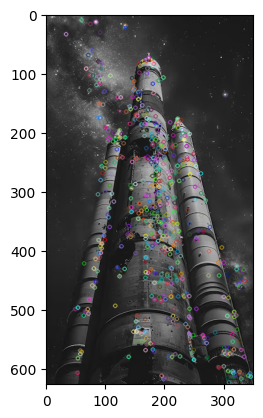

In [15]:
keypoints, des=sift(imgGrey, test=True)

In [12]:
len(keypoints)

648

In [16]:
des.shape

(648, 128)

(#keypoints, 128)

#### SURF Feature Extraction

This algorithm is patented and is excluded in this configuration; Set OPENCV_ENABLE_NONFREE CMake option and rebuild the library in function 'cv::xfeatures2d::SURF::create'

In [3]:
keypoints , des = surf(imgGrey)

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv_contrib\modules\xfeatures2d\src\surf.cpp:1028: error: (-213:The function/feature is not implemented) This algorithm is patented and is excluded in this configuration; Set OPENCV_ENABLE_NONFREE CMake option and rebuild the library in function 'cv::xfeatures2d::SURF::create'


### Getting Feature Vectors for All Images

#### SIFT Feature Extraction

In [2]:

start = time.time()
fv , kmean, invertedFile = get_feature_vectors(images_path='isolated_words_per_user',
                     algorithm='sift', 
                     numOfClusters=100)

print('Time taken:', time.time()-start)
# print mm:ss
print('Time taken:', time.strftime('%M:%S', time.gmtime(time.time()-start)))


Finished extracting BOW descriptors for 8144 images ^_^
Finished clustering BOW descriptors into 100 clusters ^_^
Finished getting BOW featureVectors for 8144 images ^_^
Time taken: 148.45172238349915
Time taken: 02:28


In [3]:
fv.shape

(8144, 100)

In [13]:
fv[0].shape

(100,)

In [7]:
len(invertedFile.keys())


100

In [ ]:
np.save('sift_fv.npy', fv)

In [ ]:

fv[0].shape # 100 cluster


(100,)

In [10]:
fv[0]

array([ 3.,  0.,  0.,  3.,  3.,  1.,  2.,  2.,  3.,  1.,  2.,  0.,  2.,
        0.,  3.,  0.,  2.,  1., 16.,  3.,  0.,  1.,  4.,  2.,  2.,  0.,
        4.,  9.,  0.,  1.,  6.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,
        1.,  2.,  0.,  2.,  3.,  0.,  3.,  3.,  2.,  4.,  2.,  4.,  3.,
        1.,  3.,  0., 10.,  4.,  0.,  5.,  4.,  0.,  0.,  3.,  2.,  0.,
        0.,  6.,  1.,  3.,  0.,  4.,  0.,  6.,  0.,  1.,  0.,  1.,  1.,
        0.,  2.,  0.,  1.,  1.,  0.,  2.,  2.,  5.,  1.,  5.,  2.,  7.,
        4.,  1.,  0.,  0.,  1.,  3.,  4.,  3.,  0.])

#### SURF Feature Extraction